In [1]:
import os.path as osp
import pandas as pd
import networkx as nx
import numpy as np
import scipy.sparse as sp

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid, Coauthor, Amazon
from torch_geometric.utils import train_test_split_edges, dense_to_sparse
from torch_geometric.nn import GAE, VGAE, APPNP,GCNConv,InnerProductDecoder
import torch_geometric.transforms as T
from torch_geometric.data import Data

import matplotlib.pyplot as plt

C:\Users\caleb\anaconda3\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
path = "hw2_data/"
dss = ['dataset1','dataset2','dataset3'] #datasets
datasets = dict()
for ds in dss:
    datasets[ds] = dict()
    datasets[ds]['content'] = pd.read_csv(path+ds+"/content.csv",delimiter = '\t',header = None)
    datasets[ds]['train'] = pd.read_csv(path+ds+"/train.csv",delimiter = ',')
    datasets[ds]['test'] = pd.read_csv(path+ds+"/test.csv",delimiter = ',')
    datasets[ds]['upload'] = pd.read_csv(path+ds+"/upload.csv",delimiter = ',')
datasets[dss[2]]['test'].head()

,id,to,from
0,E370,26,317
1,E667,196,323
2,E3190,739,468
3,E848,576,156
4,E2161,466,199


In [3]:
for dss_num in range(3):
    Content = datasets[dss[dss_num]]['content']
    Train = datasets[dss[dss_num]]['train']
    Test = datasets[dss[dss_num]]['test']
    Upload = datasets[dss[dss_num]]['upload']
    print(dss[dss_num])
    print(f'Nodes {Content.shape[0]}')
    print(f'Attributes for each node:{Content.shape[1]-1}')
    pos = Train[Train['label']==1].shape[0]
    print(f'Positive edges given: {pos}')

dataset1
Nodes 2708
Attributes for each node:1433
Positive edges given: 4324
dataset2
Nodes 3312
Attributes for each node:3703
Positive edges given: 3736
dataset3
Nodes 877
Attributes for each node:1703
Positive edges given: 1273


In [4]:
#For example:
dss_num = 0
Content = datasets[dss[dss_num]]['content']
Train = datasets[dss[dss_num]]['train']
Test = datasets[dss[dss_num]]['test']
Upload = datasets[dss[dss_num]]['upload']

In [5]:
def load_data(content,train, test):
    G = nx.Graph()
    # for easier split the edges, create 2 graph, 1 with positive edge, the other with given negative edges
    G_pos = nx.Graph()
    G_neg = nx.Graph()
    for i in range(len(content)):
        G.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        # pos and neg
        G_pos.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        G_neg.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        
    for i in range(len(train)):
        # Adding nodes into G
        '''
        if train.loc[i,'from'] not in G:
            G.add_node(train.loc[i,'from'],features = graph_node_features_dict[train.loc[i,'from']])
        if train.loc[i,'to'] not in G:
            G.add_node(train.loc[i,'to'],features = graph_node_features_dict[train.loc[i,'to']])
        ''' 
        # Adding edges
        G.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
        
        # pos and neg
        if train.loc[i,'label'] == 0: 
            G_neg.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
        else:
            G_pos.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])

    adj = nx.adjacency_matrix(G,sorted(G.nodes()))
    adj_pos = nx.adjacency_matrix(G_pos,sorted(G_pos.nodes()))
    adj_neg = nx.adjacency_matrix(G_neg,sorted(G_neg.nodes()))
    
    features = np.array(
        [features for _, features in sorted(G.nodes(data='features'), key=lambda x: x[0])])
    #features[:,:1433] = preprocess_features(features[:,:1433])
    #features[:,1433:] = preprocess_features(features[:,1433:])
    # Skip train,valid,and test mask
    
    num_features = features.shape[1]
    features = torch.FloatTensor(features)
    return adj, adj_pos, adj_neg, features, num_features

In [6]:
def preprocess_features(features):
    # Row-normalize feature matrix and convert to tuple representation
    rowsum = np.array(features.sum(1),dtype = np.float32)
    rowsum = (rowsum==0)*1+rowsum
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    features = r_mat_inv.dot(features)
    return features

In [7]:
def increase_features(content,train):
    G = nx.Graph()
    for i in range(len(content)):
        G.add_node(int(content.iloc[i,0]),features = np.array(content.iloc[i,1:]))
        
    # Adding edges
    for i in range(len(train)):
        # pos and neg
        if train.loc[i,'label'] == 1: 
            G.add_edge(train.loc[i,'from'],train.loc[i,'to'],label = train.loc[i,'label'])
            
    df = content.copy()
    df['pagerank'] = nx.pagerank(G,alpha=0.9).values()
    df['pagerank'] = df['pagerank']/np.linalg.norm(df['pagerank'])
    
    hubs,aut = nx.hits(G)
    df['hubs'] = hubs.values()
    df['hubs'] = df['hubs']/np.linalg.norm(df['hubs'])
    df['aut'] = aut.values()
    df['aut'] = df['hubs']/np.linalg.norm(df['aut'])
    
    
    features_name = ['degree','in_degree','out_degree','eigenvec','katz','closeness','info',
                     'betweenness','rwbetween','combetween','load','subgraph','harmonic','local_reach',
                    'global_reach', 'percolation','order2','trophic','laplacian']
    
    df[features_name[0]] = nx.degree_centrality(G).values()
    #df[features_name[1]] = nx.in_degree_centrality(G).values()
    #df[features_name[2]] = nx.out_degree_centrality(G).values()
    df[features_name[3]] = nx.eigenvector_centrality(G).values()
    #df[features_name[4]] = nx.katz_centrality(G).values()
    df[features_name[5]] = nx.closeness_centrality(G).values()
    #df[features_name[6]] = nx.information_centrality(G).values()
    #df[features_name[7]] = nx.betweenness_centrality(G).values()
    #print('finish feature 7')
    #df[features_name[8]] = nx.current_flow_betweenness_centrality(G).values()
    #df[features_name[9]] = nx.communicability_betweenness_centrality(G).values()
    #print('finish feature 9')
    df[features_name[10]] = nx.load_centrality(G).values()
    print('finish feature 10')
    df[features_name[11]] = nx.subgraph_centrality(G).values()
    print('finish feature 11')
    df[features_name[12]] = nx.harmonic_centrality(G).values()
    print('finish feature 12')
    #df[features_name[13]] = nx.local_reaching_centrality(G).values()
    #print('finish feature 13')
    #df[features_name[14]] = nx.global_reaching_centrality(G).values()
    #print('finish feature 14')
    #df[features_name[15]] = nx.percolation_centrality(G).values()
    #print('finish feature 15')
    #df[features_name[16]] = nx.second_order_centrality(G).values()
    #print('finish feature 16')
    #df[features_name[17]] = nx.trophic_levels(G).values()
    #print('finish feature 17')
    #df[features_name[18]] = nx.laplacian_centrality(G).values()
    #print('finish feature 18')
    
    for fea_num in [0,3,5,10,11,12]:
        df[features_name[fea_num]] /= np.linalg.norm(df[features_name[fea_num]])
    
    return df

In [8]:
newfea = False
if newfea:
    Content_mod = increase_features(Content,Train)
    g, pos, neg, features, num_features = load_data(Content_mod,Train,Test)
else:
    g, pos, neg, features, num_features = load_data(Content,Train,Test)
A = g.toarray()
edge_index,_ = dense_to_sparse(torch.tensor(A))
Apos = pos.toarray()
edge_index_pos,_ = dense_to_sparse(torch.tensor(Apos))
Aneg = neg.toarray()
edge_index_neg,_ = dense_to_sparse(torch.tensor(Aneg))
data = Data(edge_index=edge_index_pos,x=features.to(torch.float),test = torch.tensor([Test['from'],Test['to']]))
data

Data(x=[2708, 1433], edge_index=[2, 8472], test=[2, 2172])

In [9]:
dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
channels = 256

In [10]:
train_rate = 0.9
val_ratio = (1-train_rate)#/3
test_ratio = 0#(1-train_rate) / 3 * 2
data = train_test_split_edges(data.to(dev), val_ratio=val_ratio, test_ratio=0)
               #,train_pos_edge_index = edge_index_pos,neg = edge_index_neg,test = edge_index_test)
data = T.NormalizeFeatures()(data) # Should not do this normalization for new features

C:\Users\caleb\anaconda3\envs\pytorch\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [11]:
model_used = 'Hybrid'
scaling_factor = 1.8
class Encoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels, edge_index,model_used = 'GNAE'):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(in_channels, out_channels)
        self.linear2 = nn.Linear(in_channels, out_channels)
        self.propagate = APPNP(K=2, alpha=0) # Propose: 10, 0.15
        self.model_used = model_used

    def forward(self, x, edge_index,not_prop=0):
        if self.model_used  == 'GNAE':
            x = self.linear1(x)
            x = F.normalize(x,p=2,dim=1)  * scaling_factor
            x = self.propagate(x, edge_index)
            return x

        if self.model_used  == 'VGNAE':
            x_ = self.linear1(x)
            x_ = self.propagate(x_, edge_index)

            x = self.linear2(x)
            x = F.normalize(x,p=2,dim=1) * scaling_factor
            x = self.propagate(x, edge_index)
            return x, x_

        return x

In [12]:
def train(model,optimizer):
    model.train()
    optimizer.zero_grad()
    z  = model.encode(x, train_pos_edge_index)
    loss = model.recon_loss(z, train_pos_edge_index)
    if model_used  in ['VGNAE']:
        loss = loss + (1 / data.num_nodes) * model.kl_loss()
    loss.backward()
    optimizer.step()
    return loss

In [13]:
def test(pos_edge_index, neg_edge_index,model):
    model.eval()
    with torch.no_grad():
        z = model.encode(x, train_pos_edge_index)
    return model.test(z, pos_edge_index, neg_edge_index)

In [14]:
if model_used  == 'GNAE':   
    model = GAE(Encoder(data.x.size()[1], channels, data.train_pos_edge_index,model_used = 'GNAE')).to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
if model_used  == 'VGNAE':
    model = VGAE(Encoder(data.x.size()[1],channels, data.train_pos_edge_index,model_used = 'VGNAE')).to(dev)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
if model_used == 'Hybrid':
    model1 = GAE(Encoder(data.x.size()[1], channels, data.train_pos_edge_index,model_used = 'GNAE')).to(dev)
    model2 = VGAE(Encoder(data.x.size()[1],channels, data.train_pos_edge_index,model_used = 'VGNAE')).to(dev)
    optimizer1 = torch.optim.Adam(model1.parameters(), lr=0.005)
    optimizer2 = torch.optim.Adam(model2.parameters(), lr=0.005)
#model = VGAE(VariationalGCNEncoder(data.x.size()[1],channels)).to(dev)

In [15]:
data.train_mask = data.val_mask = data.test_mask = data.y = None
x, train_pos_edge_index = data.x.to(dev), data.train_pos_edge_index.to(dev)

In [16]:
test(data.val_pos_edge_index, data.val_neg_edge_index,model1)

(0.6999871457393714, 0.7214026665509832)

In [17]:
epochs = 400
tolerance = 30 #Proposed: 50
best_auc = float('-inf')
best_ap = float('-inf')
num_tol = 0
auc_list = []
ap_list = []
loss_list = []
for epoch in range(1,epochs):
    loss = train(model1,optimizer1)
    loss = float(loss)
    
    with torch.no_grad():
        #valid_pos, valid_neg = data.val_pos_edge_index, data.val_neg_edge_index
        auc, ap = test(data.val_pos_edge_index, data.val_neg_edge_index,model1)
        if auc<best_auc and ap<best_ap:
            tol += 1
            if tol>=tolerance:
                break
        else:
            best_auc = auc
            best_ap = ap
            best_model = model1.state_dict()
            tol = 0
            
        auc_list.append(auc)
        ap_list.append(ap)
        loss_list.append(loss)
        print('Epoch: {:03d}, LOSS: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
if newfea:
    model1_path = './model/VGAE_best_model_GNAE_newfea_'+str(dss_num+1)+'.pt'
else:
    model1_path = './model/VGAE_best_model_GNAE_'+str(dss_num+1)+'.pt'
torch.save(best_model, model1_path)

Epoch: 001, LOSS: 2.8617, AUC: 0.7239, AP: 0.7419
Epoch: 002, LOSS: 2.4505, AUC: 0.8227, AP: 0.8360
Epoch: 003, LOSS: 1.5336, AUC: 0.8884, AP: 0.8966
Epoch: 004, LOSS: 1.2945, AUC: 0.8762, AP: 0.8861
Epoch: 005, LOSS: 1.3824, AUC: 0.8932, AP: 0.9017
Epoch: 006, LOSS: 1.3305, AUC: 0.9217, AP: 0.9269
Epoch: 007, LOSS: 1.2165, AUC: 0.9391, AP: 0.9417
Epoch: 008, LOSS: 1.1404, AUC: 0.9469, AP: 0.9477
Epoch: 009, LOSS: 1.0949, AUC: 0.9503, AP: 0.9500
Epoch: 010, LOSS: 1.0723, AUC: 0.9518, AP: 0.9512
Epoch: 011, LOSS: 1.0620, AUC: 0.9527, AP: 0.9518
Epoch: 012, LOSS: 1.0532, AUC: 0.9529, AP: 0.9518
Epoch: 013, LOSS: 1.0461, AUC: 0.9527, AP: 0.9516
Epoch: 014, LOSS: 1.0325, AUC: 0.9520, AP: 0.9512
Epoch: 015, LOSS: 1.0149, AUC: 0.9510, AP: 0.9506
Epoch: 016, LOSS: 0.9964, AUC: 0.9495, AP: 0.9497
Epoch: 017, LOSS: 0.9792, AUC: 0.9485, AP: 0.9492
Epoch: 018, LOSS: 0.9581, AUC: 0.9482, AP: 0.9490
Epoch: 019, LOSS: 0.9484, AUC: 0.9480, AP: 0.9490
Epoch: 020, LOSS: 0.9426, AUC: 0.9481, AP: 0.9489


In [18]:
model1.load_state_dict(torch.load(model1_path))
test(data.val_pos_edge_index, data.val_neg_edge_index,model1)

(0.9498404395039373, 0.9478683321446959)

In [19]:
z = model1.encode(x, data.train_pos_edge_index)
Upload['prob'] = model1.decoder(z,data.test,sigmoid = True).detach().cpu().numpy()
Upload

,id,prob
0,E10559,0.529388
1,E4849,0.697148
2,E3964,0.875308
3,E542,0.602261
4,E331,0.885174
...,...,...
2167,E2524,0.275332
2168,E4324,0.432513
2169,E1384,0.890044
2170,E7582,0.919442


In [20]:
if newfea: 
    Upload.to_csv('output/GNAE_undirect_best_newfea_'+str(dss_num+1)+'.csv',index=False)
else:
    Upload.to_csv('output/GNAE_undirect_best_'+str(dss_num+1)+'.csv',index=False)

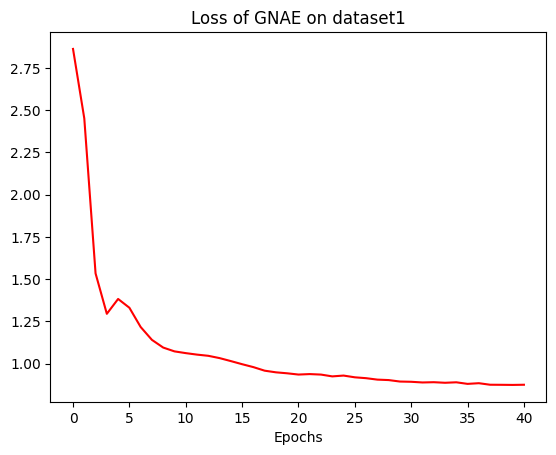

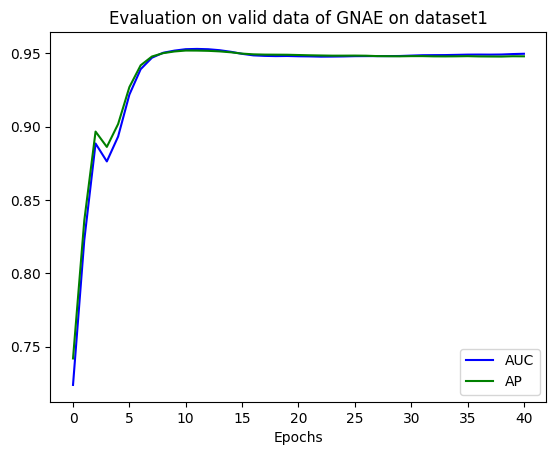

In [21]:
plt.plot(np.array(loss_list),'r',label='loss')
plt.xlabel('Epochs')
if newfea:
    title = 'Loss of GNAE with additional features on dataset'+str(dss_num+1)
else:
    title = 'Loss of GNAE on dataset'+str(dss_num+1)
plt.title(title)
plt.savefig('./plot/'+title+'.png')
plt.show()

plt.plot(np.array(auc_list),'b',label='AUC')
plt.plot(np.array(ap_list),'g',label='AP')
plt.legend()
plt.xlabel('Epochs')
if newfea:
    title = 'Evaluation on valid data of GNAE on dataset'+str(dss_num+1)+ ' with additional features'
else:
    title = 'Evaluation on valid data of GNAE on dataset'+str(dss_num+1)

plt.title(title)
plt.savefig('./plot/'+title+'.png')
plt.show()

In [22]:
test(data.val_pos_edge_index, data.val_neg_edge_index,model2)

(0.7008478223205852, 0.7219033389373692)

In [23]:
epochs = 400
tolerance = 30 #Proposed: 50
best_auc = float('-inf')
best_ap = float('-inf')
num_tol = 0
auc_list = []
ap_list = []
loss_list = []
for epoch in range(1,epochs):
    loss = train(model2,optimizer2)
    loss = float(loss)
    
    with torch.no_grad():
        #valid_pos, valid_neg = data.val_pos_edge_index, data.val_neg_edge_index
        auc, ap = test(data.val_pos_edge_index, data.val_neg_edge_index,model2)
        if auc<best_auc and ap<best_ap:
            tol += 1
            if tol>=tolerance:
                break
        else:
            best_auc = auc
            best_ap = ap
            best_model = model2.state_dict()
            tol = 0
            
        auc_list.append(auc)
        ap_list.append(ap)
        loss_list.append(loss)
        print('Epoch: {:03d}, LOSS: {:.4f}, AUC: {:.4f}, AP: {:.4f}'.format(epoch, loss, auc, ap))
if newfea:
    model2_path = './model/VGAE_best_model_VGNAE_newfea_'+str(dss_num+1)+'.pt'
else:
    model2_path = './model/VGAE_best_model_VGNAE_'+str(dss_num+1)+'.pt'
torch.save(best_model, model2_path)

Epoch: 001, LOSS: 14.4633, AUC: 0.7018, AP: 0.7225
Epoch: 002, LOSS: 14.2920, AUC: 0.7032, AP: 0.7236
Epoch: 003, LOSS: 13.9734, AUC: 0.7042, AP: 0.7243
Epoch: 004, LOSS: 14.0835, AUC: 0.7052, AP: 0.7251
Epoch: 005, LOSS: 13.6121, AUC: 0.7059, AP: 0.7257
Epoch: 006, LOSS: 13.3054, AUC: 0.7066, AP: 0.7263
Epoch: 007, LOSS: 13.2644, AUC: 0.7072, AP: 0.7268
Epoch: 008, LOSS: 13.1592, AUC: 0.7079, AP: 0.7273
Epoch: 009, LOSS: 12.8095, AUC: 0.7085, AP: 0.7279
Epoch: 010, LOSS: 12.5011, AUC: 0.7091, AP: 0.7284
Epoch: 011, LOSS: 12.6963, AUC: 0.7097, AP: 0.7289
Epoch: 012, LOSS: 12.4242, AUC: 0.7102, AP: 0.7294
Epoch: 013, LOSS: 12.0932, AUC: 0.7109, AP: 0.7300
Epoch: 014, LOSS: 11.7266, AUC: 0.7117, AP: 0.7306
Epoch: 015, LOSS: 11.8961, AUC: 0.7125, AP: 0.7312
Epoch: 016, LOSS: 11.7899, AUC: 0.7133, AP: 0.7318
Epoch: 017, LOSS: 11.3593, AUC: 0.7142, AP: 0.7326
Epoch: 018, LOSS: 11.1574, AUC: 0.7153, AP: 0.7334
Epoch: 019, LOSS: 11.0523, AUC: 0.7163, AP: 0.7342
Epoch: 020, LOSS: 11.2095, AUC:

In [24]:
model2.load_state_dict(torch.load(model2_path))
test(data.val_pos_edge_index, data.val_neg_edge_index,model2)

(0.9409318780074778, 0.9387271344836794)

In [25]:
z = model2.encode(x, data.train_pos_edge_index)
Upload['prob'] = model2.decoder(z,data.test,sigmoid = True).detach().cpu().numpy()
Upload

,id,prob
0,E10559,0.583566
1,E4849,0.792475
2,E3964,0.878109
3,E542,0.564775
4,E331,0.924848
...,...,...
2167,E2524,0.257323
2168,E4324,0.543136
2169,E1384,0.912330
2170,E7582,0.951418


In [26]:
if newfea: 
    Upload.to_csv('output/VGNAE_undirect_best_newfea_'+str(dss_num+1)+'.csv',index=False)
else:
    Upload.to_csv('output/VGNAE_undirect_best_'+str(dss_num+1)+'.csv',index=False)

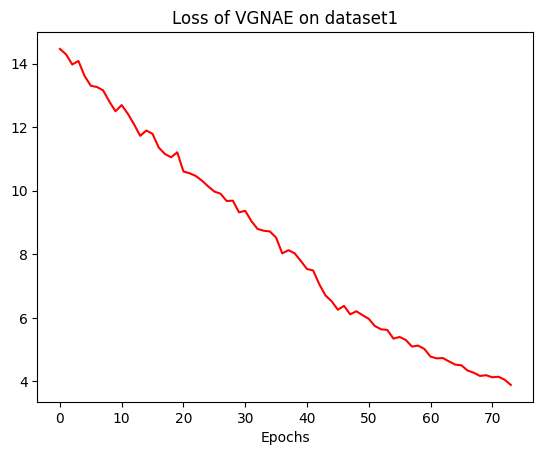

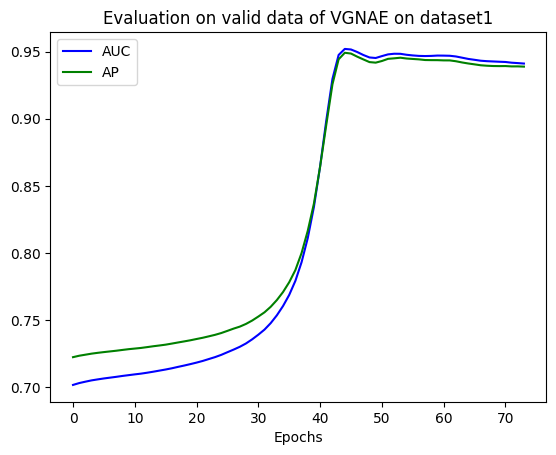

In [27]:
plt.plot(np.array(loss_list),'r',label='loss')
plt.xlabel('Epochs')
if newfea:
    title = 'Loss of VGNAE with additional features on dataset'+str(dss_num+1)
else:
    title = 'Loss of VGNAE on dataset'+str(dss_num+1)
plt.title(title)
plt.savefig('./plot/'+title+'.png')
plt.show()

plt.plot(np.array(auc_list),'b',label='AUC')
plt.plot(np.array(ap_list),'g',label='AP')
plt.legend()
plt.xlabel('Epochs')
if newfea:
    title = 'Evaluation on valid data of VGNAE on dataset'+str(dss_num+1)+ ' with additional features'
else:
    title = 'Evaluation on valid data of VGNAE on dataset'+str(dss_num+1)
plt.title(title)
plt.savefig('./plot/'+title+'.png')
plt.show()

In [28]:
z1 = model1.encode(x, data.train_pos_edge_index)
z2 = model2.encode(x, data.train_pos_edge_index)
Upload['prob'] = (2*model1.decoder(z1,data.test,sigmoid = True).detach().cpu().numpy()+model2.decoder(z2,data.test,sigmoid = True).detach().cpu().numpy())/3
Upload

,id,prob
0,E10559,0.547447
1,E4849,0.728923
2,E3964,0.876241
3,E542,0.589766
4,E331,0.898399
...,...,...
2167,E2524,0.269329
2168,E4324,0.469387
2169,E1384,0.897473
2170,E7582,0.930101


In [29]:
if newfea: 
    Upload.to_csv('output/Hybrid_undirect_imb_best_newfea_'+str(dss_num+1)+'.csv',index=False)
else:
    Upload.to_csv('output/Hybrid_undirect_imb_best_'+str(dss_num+1)+'.csv',index=False)